# Macroeconomic forecasting

Taken from: https://blog.cambridgespark.com/macroeconomic-forecasting-345b48b7b12b

## Macroeconomic forecasting with Gaussian processes

In [1]:
#Install packages
#!pip install pandas
#!pip install statsmodels
#!pip3 install sklearn

### Configuration

In [26]:
# Forecasting years, number of years to use for out-of-sample 
# evaluation (We will create one forecast per country for each year
# which we compare to the actual GDP)
nyears = 10
# Number of lags to use for GP regression
lags = 5
# Indicator labels and names in the World Bank API
indicators  = {"gdp"        : "NY.GDP.MKTP.CD",
               "population" :    "SP.POP.TOTL",
               "inflation"  : "FP.CPI.TOTL.ZG"}
nindicators = len(indicators)
# The variable to forecast, should be one of the indicator labels
target_variable = "gdp"
# Countries to include in the data, specified as ISO country codes
#countries  = ['au','ca','de','es','fr','gb','jp','us']

countries  = ['de','fr','gb','jp','chn','us', "co", 'cl', 'ar', 'br', 'mx', 'pa', 'do']
ncountries = len(countries)
# Start and end year for the data set
start_year = 1976
#end_year   = 2020
end_year   = 2021

### Data

In [27]:
import requests
import pandas as pd
template_url = "http://api.worldbank.org/v2/countries/{0}/indi"
template_url +="cators/{1}?date={2}:{3}&format=json&per_page=999"
# Countries should be ISO identifiers separated by semi-colon
country_str = ';'.join(countries)
raw_data = pd.DataFrame()
for label, indicator in indicators.items():
# Fill in the template URL
    url = template_url.format(country_str, indicator, 
                                  start_year, end_year)
    
    # Request the data
    json_data = requests.get(url)
    
    # Convert the JSON string to a Python object
    json_data = json_data.json()
    
    # The result is a list where the first element is meta-data, 
    # and the second element is the actual data
    json_data = json_data[1]
    
    # Loop over all data points, pick out the values and append 
    # them to the data frame
    for data_point in json_data:
        
        country = data_point['country']['id']
        
        # Create a variable for each country and indicator pair
        item    = country + '_' + label
        
        year    = data_point['date']
        
        value   = data_point['value']
        
        # Append to data frame
        new_row  = pd.DataFrame([[item, year, value]],
                                columns=['item', 'year', 'value'])
        raw_data = raw_data.append(new_row)
# Pivot the data to get unique years along the columns,
# and variables along the rows
raw_data = raw_data.pivot('year', 'item', 'value')
# Let's look at the first few rows and columns
print('\n', raw_data.iloc[:10, :5], '\n')


 item        AR_gdp  AR_inflation  AR_population        BR_gdp  BR_inflation
year                                                                       
1976  5.116950e+10           NaN     26264681.0  1.531689e+11           NaN
1977  5.678100e+10           NaN     26661397.0  1.763441e+11           NaN
1978  5.808287e+10           NaN     27061041.0  2.002786e+11           NaN
1979  6.925233e+10           NaN     27471046.0  2.213382e+11           NaN
1980  7.696192e+10           NaN     27896532.0  2.373935e+11           NaN
1981  7.867684e+10           NaN     28338514.0  2.580152e+11    101.725073
1982  8.430749e+10           NaN     28794550.0  2.713141e+11    100.543359
1983  1.039791e+11           NaN     29262049.0  1.896565e+11    135.027682
1984  7.909200e+10           NaN     29737097.0  1.883400e+11    192.121733
1985  8.841667e+10           NaN     30216284.0  1.761237e+11    225.989665 



### Exploration

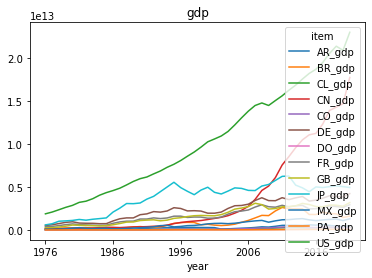

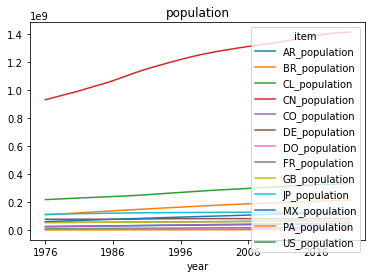

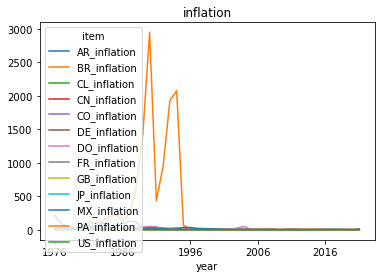

In [28]:
import matplotlib.pyplot as plt
for lab in indicators.keys():
    
    indicator = raw_data[[x for x in raw_data.columns 
                              if x.split("_")[-1] == lab]]
    indicator.plot(title=lab)
    plt.show()

### Transformation

In [29]:
import numpy as np
# Calculate rates of change instead of absolute levels
# (Runtime warning expected due to NaN)
data = np.log(raw_data).diff().iloc[1:,:]
# Set NaN to zero
data.fillna(0, inplace=True)
# Subtract the mean from each series
data = data - data.mean()
# Convert to date type
data.index = pd.to_datetime(data.index, format='%Y')
# Put the target variable into a separate data frame
target = data[[x for x in data.columns 
                   if x.split("_")[-1] == target_variable]]

### Evaluation
All models are evaluated in the same way. For each of the forecasting years (the last years of data) we train the model using the previous years and create a forecast for each country. For each forecast we calculate the squared error versus the true value, and then calculate the mean over countries and years, before taking the square root to arrive at a root mean squared error (RMSE). In other words
$$
RMSE = \sqrt{ \frac{1}{m}\sum_{i=1}^{m} (\hat{y_{i}} - y_{i})^2}
$$

where $\hat{y_{i}}$ is a forecast, $y_{i}$ is an actual value of the target variable and mm is the number of forecasts we create (the number of forecasting years times the number of countries).

### Baseline forecasts
We will first establish the performance of a simple baseline method, which will be used as a comparison to subsequent methods. Our baseline method will simply predict the same rate of change as the previous observation of the target variable.
Only if a more complicated method significantly outperforms a naive baseline forecast should it be preferred, in keeping with both the principle of Occam’s Razor, and the KISS principle in software development.

In [30]:
errors = target.iloc[-nyears:] - target.shift().iloc[-nyears:]
# Root mean squared error
rmse = errors.pow(2).sum().sum()/(nyears*ncountries)**.5
print('\n\t' + '-' * 18)
print("\t| Error: ", np.round(rmse, 4), '|')
print('\t' + '-' * 18 + '\n')


	------------------
	| Error:  0.2125 |
	------------------



### Multivariate time series
We investigate the performance of a multivariate time series regression, also termed a Vector Autoregression (VAR) in econometrics. The model takes the form

$$
y_{t} = \sum_{i=1}^{d} \sum_{i=1}^{p} \beta_{ij} x_{i, t-j} + \varepsilon_{t}
$$

where 𝑑 is the number of independent variables, 𝜀 is the number of lags, εtεt is an error term and the $\beta_{i},j\beta_{i},j$ are parameters to be estimated.
To read more about time series analysis, a good introductory book is “Introduction to Time Series and Forecasting” by Brockwell and Davis, and two more advanced books are “Time Series: Theory and Methods”, also by Brockwell and Davis, and “Time Series Analysis” by Hamilton.
To fit the model we use the ```statsmodels``` package, whose ```VAR``` implementation uses least squares to estimate the parameters. We train the model using one lag, i.e. regressing the target variable on the most recent previous values of the independent variables, but automatic methods to choose the number of lags are also supported in the ```statsmodels``` package, such as the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).

In [31]:
from statsmodels.tsa.api import VAR
# Sum of squared errors
sse = 0
for t in range(nyears):
    
    # Create a VAR model
    model = VAR(target.iloc[t:-nyears+t], freq='AS')
    
    # Estimate the model parameters
    results = model.fit(maxlags=1)
    
    actual_values = target.values[-nyears+t+1]
    
    forecasts = results.forecast(target.values[:-nyears+t], 1)
    forecasts = forecasts[0,:ncountries]
sse += ((actual_values - forecasts)**2).sum()
# Root mean squared error
rmse = (sse / (nyears * ncountries))**.5
print('\n\t' + '-' * 18)
print("\t| Error: ", np.round(rmse, 4), '|')
print('\t' + '-' * 18 + '\n')


	------------------
	| Error:  0.1121 |
	------------------



We see that the error is about the same as the baseline model, which argues against using the more complicated VAR model for macroeconomic forecasting with the current data.

## Gaussian process regression
We will now attempt to forecast GDP using Gaussian process regression. Our model is similar to before, and is given by
$$
y_{t} = f(x_{t}) + \varepsilon_{t} \; \; t=1,2,...,n
$$
where the $y_{t}$ are observations of the target variable, each $x_{t}$ is a vector of observations of an independent (predictor) variable, $f(x)$ is the regression function and the noise term $\varepsilon_{t}$ has a normal (Gaussian) distribution with variance $\alpha$. For each out-of-sample forecast, we will put the $n\times n$ previous observations of the target variable $y$ into a column vector which we will denote $y$. We will also let $X$ denote the matrix of the $n\times n$  previous observations of the predictor variable, where each observation occupies a row in the matrix. Here each observation will include lagged values of our variables from before (countries and indicators)

Instead of the regression function $f(x)$ being a linear function with unknown parameters, the function is now random, such that its value at each point $x_{t}$ is a normally distributed random variable, and such that the covariance between two random variables $f(x_{t})$ and $f(x_{s})$ is given by a so-called covariance function (or kernel) $k(x_{t}, x_{s})$, which needs to be specified. The function $f(x_{t})$ is called a Gaussian process. Since the error term is normally distributed the target values will also be normally distributed, with covariance equal to  $k(x_{t}, x_{s}) + a$ if $t = s$ and $k(x_{t}, x_{s})$ otherwise.


Suppose we want to estimate the model using nn data points for $y_{t}$ and $x_{t}$ and that we have a new test point $f(x_{n+1})$, based on which we want to make a forecast $\hat{y_{n+1}}$. The conditional distribution of $f(x_{n+1})$ given $y, X \; \text{and} \; x_{n+1}$ is then also normally distributed and we can ta ke our forecast $\hat{y_{n+1}}$ to be the conditional expected value of $f(x_{n+1})$. By a well-known formula for the multivariate Gaussian distribution it is given by

$$
E[f(x_{n+1})| {\bf{y}}, X, x_{n+1}] = {\bf{y}}^T (\alpha I + K)^{-1} {\bf{k}}
$$

where $K$ is an $n×n$ matrix where the entry on row $t$ and column $s$ is given by $k(x_{s},x_{t})$, $I$ is the identity matrix, and ${\bf{k}}$ is a length-$n$ column vector with entry $t$ given by $k(x_{t},x_{n+1})$

To read more about Gaussian process methods, which can also be used for classification, see for example the book “Gaussian Processes in Machine Learning” by Rasmussen and Williams.

To implement Gaussian process regression we make use of ready-made functionality in the ```scikit-learn package``` (see this link for documentation). For each forecasting year we create the vector 𝘺 of past observations of the target variable, and the data matrix 𝑋 of observations of the independent variable. We feed these into the ```GaussianProcessRegressor``` class to estimate the model, and then make a forecast for the following year. Like before, we calculate the error of a number of forecasts which we sum into a root mean squared error.
We will use the common Gaussian covariance function, which is given by

$$
k(x_{t}, x_{s}) = e^{||x_{t}-x_{s}||^{2}/\sigma^2}
$$
where $||V||$ is the length of the vector $vv$, and $\sigma\sigma$ is a parameter.

In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
# We set the parameter of the covariance function to
# approximately equal to the median distance between data points,
# a common heuristic for this covariance function. The 'alpha' 
# argument is the noise variance, which we set equal to the 
# covariance parameter.
gpr = GaussianProcessRegressor(kernel=RBF(0.1), alpha=0.1)
# Number of data points for estimation/fitting for each forecast
ndata = target.shape[0] - nyears - lags
# Sum of squared errors
sse = 0
for t in range(nyears):
    
    # Observations for the target variables
    y = np.zeros((ndata, ncountries))
# Observations for the independent variables
    X = np.zeros((ndata, lags*ncountries*nindicators))
    
    for i in range(ndata):
        
        y[i] = target.iloc[t+i+1]
        X[i] = data.iloc[t+i+2:t+i+2+lags].values.flatten()
        
    gpr.fit(X, y)
    
    x_test   = np.expand_dims(data.iloc[t+1:t+1+lags].values.flatten(), 0)
    forecast = gpr.predict(x_test)
    
    sse += ((target.iloc[t].values - forecast)**2).sum()
    
rmse = (sse / (nyears * ncountries))**.5
print('\n\t' + '-' * 18)
print("\t| Error: ", np.round(rmse, 4), '|')
print('\t' + '-' * 18 + '\n')


	------------------
	| Error:  0.1658 |
	------------------



With VAR we obtain the best results so far

## Post-estimation

In [33]:
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Oct, 2022
Time:                     14:12:24
--------------------------------------------------------------------
No. of Equations:         13.0000    BIC:                   -64.2726
Nobs:                     34.0000    HQIC:                  -69.6568
Log likelihood:           786.363    FPE:                6.78543e-32
AIC:                     -72.4432    Det(Omega_mle):     7.66774e-34
--------------------------------------------------------------------
Results for equation AR_gdp
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.034675         0.055042           -0.630           0.529
L1.AR_gdp        -0.350881         0.182306           -1.925           0.054
L1.BR_gdp         0.999897         0.450688            2.219           0.02

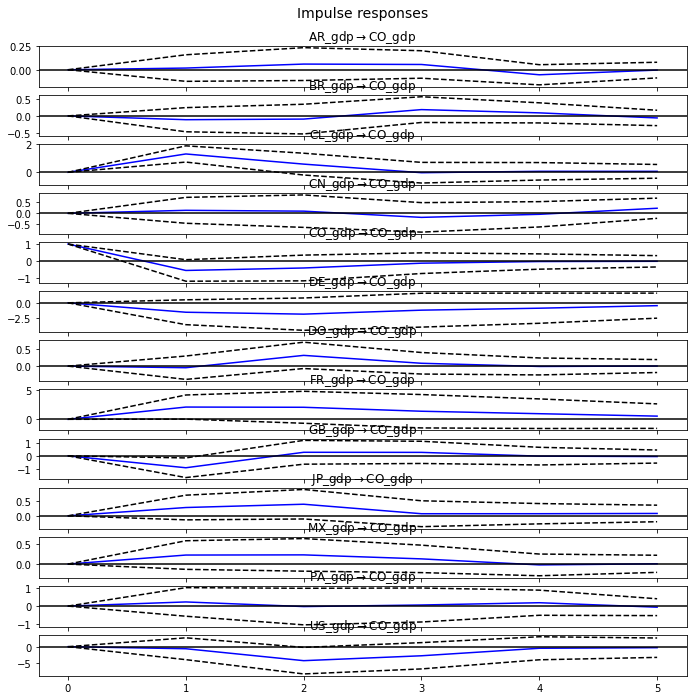

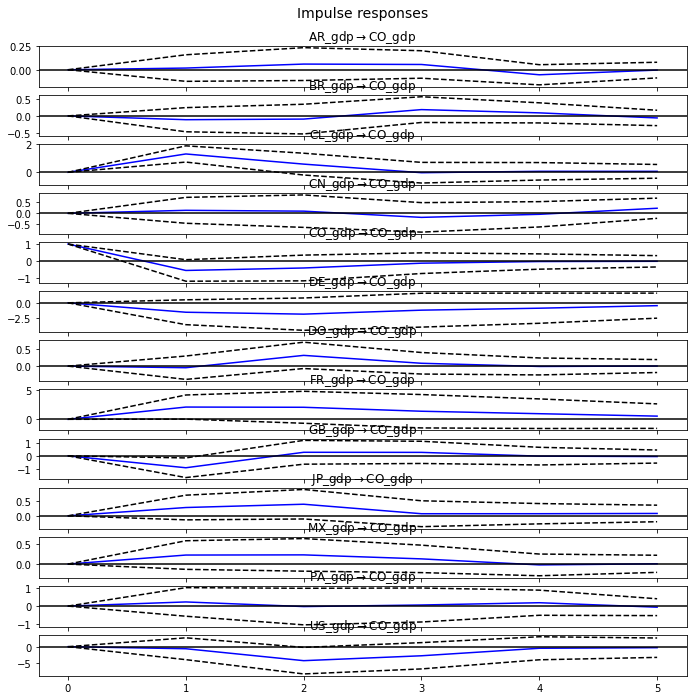

In [34]:
irf = results.irf(5)
irf.plot(response='CO_gdp')

In [35]:
data.columns

Index(['AR_gdp', 'AR_inflation', 'AR_population', 'BR_gdp', 'BR_inflation',
       'BR_population', 'CL_gdp', 'CL_inflation', 'CL_population', 'CN_gdp',
       'CN_inflation', 'CN_population', 'CO_gdp', 'CO_inflation',
       'CO_population', 'DE_gdp', 'DE_inflation', 'DE_population', 'DO_gdp',
       'DO_inflation', 'DO_population', 'FR_gdp', 'FR_inflation',
       'FR_population', 'GB_gdp', 'GB_inflation', 'GB_population', 'JP_gdp',
       'JP_inflation', 'JP_population', 'MX_gdp', 'MX_inflation',
       'MX_population', 'PA_gdp', 'PA_inflation', 'PA_population', 'US_gdp',
       'US_inflation', 'US_population'],
      dtype='object', name='item')

In [37]:
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anacond

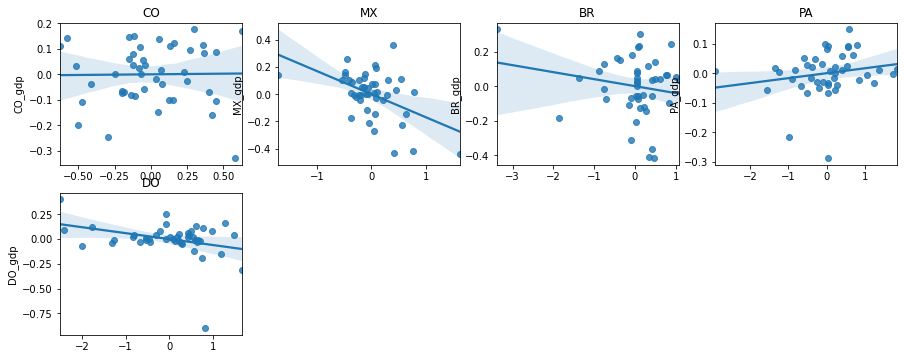

In [41]:
paises = [ 'CO',  'MX', 'BR', 'PA', 'DO']
plt.figure(figsize=(15, 12))
for n, col in enumerate(paises):
    # add a new subplot iteratively
    ax = plt.subplot(4, 4, n + 1)

    # filter df and plot ticker on the new subplot axis
    col_gdp = col + '_gdp'
    col_cpi = col + '_inflation'
    df_temp = data[[col_gdp, col_cpi]]
    
    y = df_temp[col_gdp]
    x = df_temp[col_cpi]
    sns.regplot(x,y)
    
    ax.set_title(col)
    ax.set_xlabel("")

In [ ]:
data[['']]

<AxesSubplot:xlabel='year'>

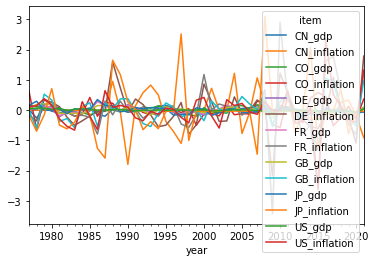

In [11]:
paises = ['CN', 'CO', 'DE', 'FR', 'GB', 'JP', 'US']
for pais in paises:
    col_gdp = pais + '_gdp'
    col_cpi = pais + '_inflation'
    df_temp

In [12]:
data_var = data[['CN_gdp',  'CO_gdp', 'CO_inflation',
       'CO_population', 'DE_gdp', 'FR_gdp',
        'GB_gdp', 'JP_gdp',  'US_gdp',
       'US_inflation']]
data_var

item,CN_gdp,CO_gdp,CO_inflation,CO_population,DE_gdp,FR_gdp,GB_gdp,JP_gdp,US_gdp,US_inflation
year,,,,,,,,,,
1977-01-01,0.022385,0.171261,0.626397,0.006050,0.097848,0.051186,0.064859,0.160259,0.049760,0.109334
1978-01-01,-0.262345,0.110854,-0.628494,0.006054,0.162970,0.165195,0.186192,0.292710,0.066127,0.145723
1979-01-01,0.070308,0.116080,0.360821,0.005953,0.127609,0.146083,0.209558,-0.007324,0.055150,0.374122
1980-01-01,-0.035786,0.111396,0.131412,0.005772,0.028764,0.087099,0.194083,-0.000713,0.028187,0.171133
1981-01-01,-0.081103,0.018563,0.072365,0.005608,-0.218121,-0.176301,-0.101912,0.050472,0.059746,-0.285248
1982-01-01,-0.059467,0.001385,-0.070678,0.005462,-0.076861,-0.097018,-0.106889,-0.119169,-0.013968,-0.536511
1983-01-01,0.012132,-0.073240,-0.199528,0.005247,-0.054171,-0.089601,-0.108801,0.044225,0.027516,-0.660828
1984-01-01,0.013933,-0.079493,-0.137226,0.004952,-0.107509,-0.099438,-0.117336,0.011261,0.049586,0.277281
1985-01-01,0.068962,-0.159007,0.419504,0.004606,-0.036369,-0.004459,0.000327,0.011920,0.016262,-0.207449


In [13]:
model = VAR(data_var)
for i in [1,2,3]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -57.295486347481585
BIC :  -52.835012262685936
FPE :  1.458483525903569e-25
HQIC:  -55.64132752445269 

Lag Order = 2
AIC :  -59.64665253303623
BIC :  -51.045442665695575
FPE :  3.100378883037261e-26
HQIC:  -56.47479215638917 

Lag Order = 3
AIC :  -69.59498260943357
BIC :  -56.76932590305633
FPE :  3.833284505748714e-29
HQIC:  -64.89387216387873 



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [14]:
x = model.select_order(maxlags=3)
x.summary()

,AIC,BIC,FPE,HQIC
0,-55.43,-55.02,8.422e-25,-55.28
1,-57.99,-53.44,7.379e-26,-56.33
2,-59.42,-50.74,4.175e-26,-56.24
3,-69.59*,-56.77*,3.833e-29*,-64.89*


### SVAR

https://www.statsmodels.org/dev/vector_ar.html

In [15]:
from statsmodels.tsa.api.vector_ar.svar_model import SVAR
svar = SVAR(data_var)

ModuleNotFoundError: No module named 'statsmodels.tsa.api.vector_ar'; 'statsmodels.tsa.api' is not a package

# Reg

In [20]:
import statsmodels.api as sm

In [27]:
data['1980-01-01':'1990-01-01']

item,CN_gdp,CN_inflation,CN_population,CO_gdp,CO_inflation,CO_population,DE_gdp,DE_inflation,DE_population,FR_gdp,...,FR_population,GB_gdp,GB_inflation,GB_population,JP_gdp,JP_inflation,JP_population,US_gdp,US_inflation,US_population
year,,,,,,,,,,,,,,,,,,,,,
1980-01-01,-0.035786,-0.005710,0.003273,0.111396,0.131412,0.005772,0.028764,0.256578,0.000755,0.087099,...,-0.000428,0.194083,0.333488,-0.002814,-0.000713,0.708760,0.005474,0.028187,0.171133,0.000259
1981-01-01,-0.081103,-0.005710,0.003541,0.018563,0.072365,0.005608,-0.218121,0.113320,0.000204,-0.176301,...,-0.000008,-0.101912,-0.372052,-0.003661,0.050472,-0.493440,0.004877,0.059746,-0.285248,0.000477
1982-01-01,-0.059467,-0.005710,0.005458,0.001385,-0.070678,0.005462,-0.076861,-0.231280,-0.002271,-0.097018,...,0.000326,-0.106889,-0.281090,-0.004368,-0.119169,-0.617157,0.004529,-0.013968,-0.536511,0.000196
1983-01-01,0.012132,-0.005710,0.005181,-0.073240,-0.199528,0.005247,-0.054171,-0.504851,-0.003941,-0.089601,...,0.000588,-0.108801,-0.581701,-0.003668,0.044225,-0.400412,0.004548,0.027516,-0.660828,-0.000193
1984-01-01,0.013933,-0.005710,0.003852,-0.079493,-0.137226,0.004952,-0.107509,-0.354299,-0.004776,-0.099438,...,0.000719,-0.117336,0.115325,-0.002427,0.011261,0.140591,0.004075,0.049586,0.277281,-0.000679
1985-01-01,0.068962,-0.005710,0.004348,-0.159007,0.419504,0.004606,-0.036369,-0.192409,-0.003554,-0.004459,...,0.000743,0.000327,0.243891,-0.001740,0.011920,-0.140702,0.003851,0.016262,-0.207449,-0.000476
1986-01-01,-0.134095,-0.005710,0.005605,-0.065731,-0.202692,0.004221,0.309911,-0.040254,-0.000862,0.286789,...,0.000789,0.148238,-0.529873,-0.001693,0.348828,-1.261146,0.002916,-0.001744,-0.639323,-0.000095
1987-01-01,-0.202415,-0.005710,0.006767,-0.026976,0.249671,0.003861,0.169184,-0.040254,0.000217,0.145462,...,0.000846,0.156090,0.232838,-0.001883,0.150109,-1.585643,0.002412,0.002711,0.643454,-0.000399
1988-01-01,0.029281,0.950006,0.006832,0.008054,0.225824,0.003593,0.029838,1.588674,0.002587,0.040864,...,0.000778,0.141812,0.043401,-0.001789,0.145541,1.648504,0.001753,0.019864,0.092405,-0.000257


In [17]:
data.columns

Index(['CN_gdp', 'CN_inflation', 'CN_population', 'CO_gdp', 'CO_inflation',
       'CO_population', 'DE_gdp', 'DE_inflation', 'DE_population', 'FR_gdp',
       'FR_inflation', 'FR_population', 'GB_gdp', 'GB_inflation',
       'GB_population', 'JP_gdp', 'JP_inflation', 'JP_population', 'US_gdp',
       'US_inflation', 'US_population'],
      dtype='object', name='item')

In [23]:
df_reg = data[['CO_gdp','CO_inflation','CN_gdp',  
         'US_gdp','US_inflation', 'DE_gdp',  'GB_gdp',  'JP_gdp']]
y = df_reg[['CO_gdp']]
x = df_reg.drop(columns = ['CO_gdp'])
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CO_gdp   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     4.886
Date:                Tue, 11 Oct 2022   Prob (F-statistic):           0.000561
Time:                        15:42:29   Log-Likelihood:                 48.432
No. Observations:                  45   AIC:                            -80.86
Df Residuals:                      37   BIC:                            -66.41
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.735e-18      0.014   1.28e-16      1.000      -0.027       0.027
CO_inflation    -0.0748      0.047     -1.580      0.123      -0.171       0.021
CN_gdp           0.6135      0.178      3.454      0.001       0.254       0.974
US_gdp           1.1556      0.618      1.870      0.069      -0.097       2.408
US_inflation     0.0376      0.022      1.686      0.100      -0.008       0.083
DE_gdp           0.1625      0.241      0.675      0.504      -0.325       0.650
GB_gdp           0.1675      0.249      0.673      0.505      -0.337       0.672
JP_gdp           0.1085      0.164      0.662      0.512      -0.224       0.441
==============================================================================
Omnibus:                        2.116   Durbin-Watson:                   1.461
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                1.945
Skew:                          -0.489   Prob(JB):                        0.378
Kurtosis:                       2.714   Cond. No.                         48.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# GDP Potencial

Hacer hodrick y prescott con lambda de 200, 1600. Según mauricio cárdenas hacerlo con 1600 con la mayor historia de tiempo min 30 años que está por debajo de 0 es recesión.